In [1]:
# !pip install pandas
import pandas as pd
import os
import ast

In [11]:
file_dir = "./simdata/multi_pose/"

def get_df_from_lines(data, parameters):
    headers = data[0].split(",")
    data_dict = {}
    for line in data[1:]:
        line_info = line.split(",")
        for idx, header in enumerate(headers):
            if header not in data_dict:
                data_dict[header] = [float(line_info[idx])]
            else:
                data_dict[header].append(float(line_info[idx]))

    df = pd.DataFrame(data_dict)
    parameters_dict = {line.split(",")[0]: "".join(line.split(",")[1:]) for line in parameters}
    df["parameters"] = str(parameters_dict)
    df["N_kappa"] = ast.literal_eval(parameters_dict["N_kappa"]) 
    df["state_init"] = parameters_dict["state_init"]

    return df


df_list = []
for root, dirs, files in os.walk(file_dir):
    for fn in files:
        if not fn.endswith(".csv"):
            continue
        file_path = os.path.join(root, fn)

        with open(file_path) as f:
            data = f.read().splitlines()

        parameters = []
        for from_line, line in enumerate(data):
            if line.startswith("t [s]"):
                break

            parameters.append(line)
        df = get_df_from_lines(data[from_line:], parameters)
        df_list.append(df)

concat_df = pd.concat(df_list)

In [12]:
df_group_info = concat_df.groupby(['N_kappa', 'state_init']).size()
df_group_info

N_kappa       state_init                           
[0.5 9 -2.5]  [ 0.         -3.          1.57079633]    143
              [ 0.         -3.          3.14159265]    143
              [ 0.e+00 -3.e+00  1.e-03]                143
              [ 3.         -3.          1.57079633]    143
              [ 3.         -3.          3.14159265]    143
                                                      ... 
[1.5 9 -2.5]  [3.         0.         3.14159265]       143
              [3.         3.         1.57079633]       143
              [3.         3.         3.14159265]       143
              [3.e+00 0.e+00 1.e-03]                   143
              [3.e+00 3.e+00 1.e-03]                   143
Length: 96, dtype: int64

In [13]:
chosen_kappa = concat_df["N_kappa"].iloc[0]

sub_df_1 = concat_df[concat_df["N_kappa"] == chosen_kappa]
pose_list = sub_df_1["state_init"].unique()
pose_list
sub_df_2 = sub_df_1[sub_df_1["state_init"] == pose_list[0]]
sub_df_2
pose_list

array(['[-3.e+00 -3.e+00  1.e-03]', '[-3.e+00  0.e+00  1.e-03]',
       '[ 3.e+00 -3.e+00  1.e-03]', '[-3.e+00  3.e+00  1.e-03]',
       '[3.e+00 0.e+00 1.e-03]', '[ 0.e+00 -3.e+00  1.e-03]',
       '[0.e+00 3.e+00 1.e-03]', '[3.e+00 3.e+00 1.e-03]',
       '[3.         3.         3.14159265]',
       '[3.         0.         3.14159265]',
       '[0.         3.         3.14159265]',
       '[ 3.         -3.          3.14159265]',
       '[-3.         -3.          3.14159265]',
       '[-3.          3.          3.14159265]',
       '[-3.          0.          3.14159265]',
       '[ 0.         -3.          3.14159265]',
       '[-3.          3.          1.57079633]',
       '[3.         0.         1.57079633]',
       '[ 0.         -3.          1.57079633]',
       '[0.         3.         1.57079633]',
       '[-3.          0.          1.57079633]',
       '[-3.         -3.          1.57079633]',
       '[ 3.         -3.          1.57079633]',
       '[3.         3.         1.57079633]']

In [34]:
import re

def process_string(input_string):
    # Reduce multiple spaces to one space
    reduced_spaces = re.sub(r'\s+', ' ', input_string)
    # Remove leading and trailing spaces or special characters
    trimmed = re.sub(r'^[\s\W_]+|[\s\W_]+$', '', reduced_spaces)
    # Replace remaining spaces with commas
    result = re.sub(r' ', ',', trimmed)
    return result

def extract_pose_string(text):
    return ast.literal_eval(f"[{process_string(text)}]")


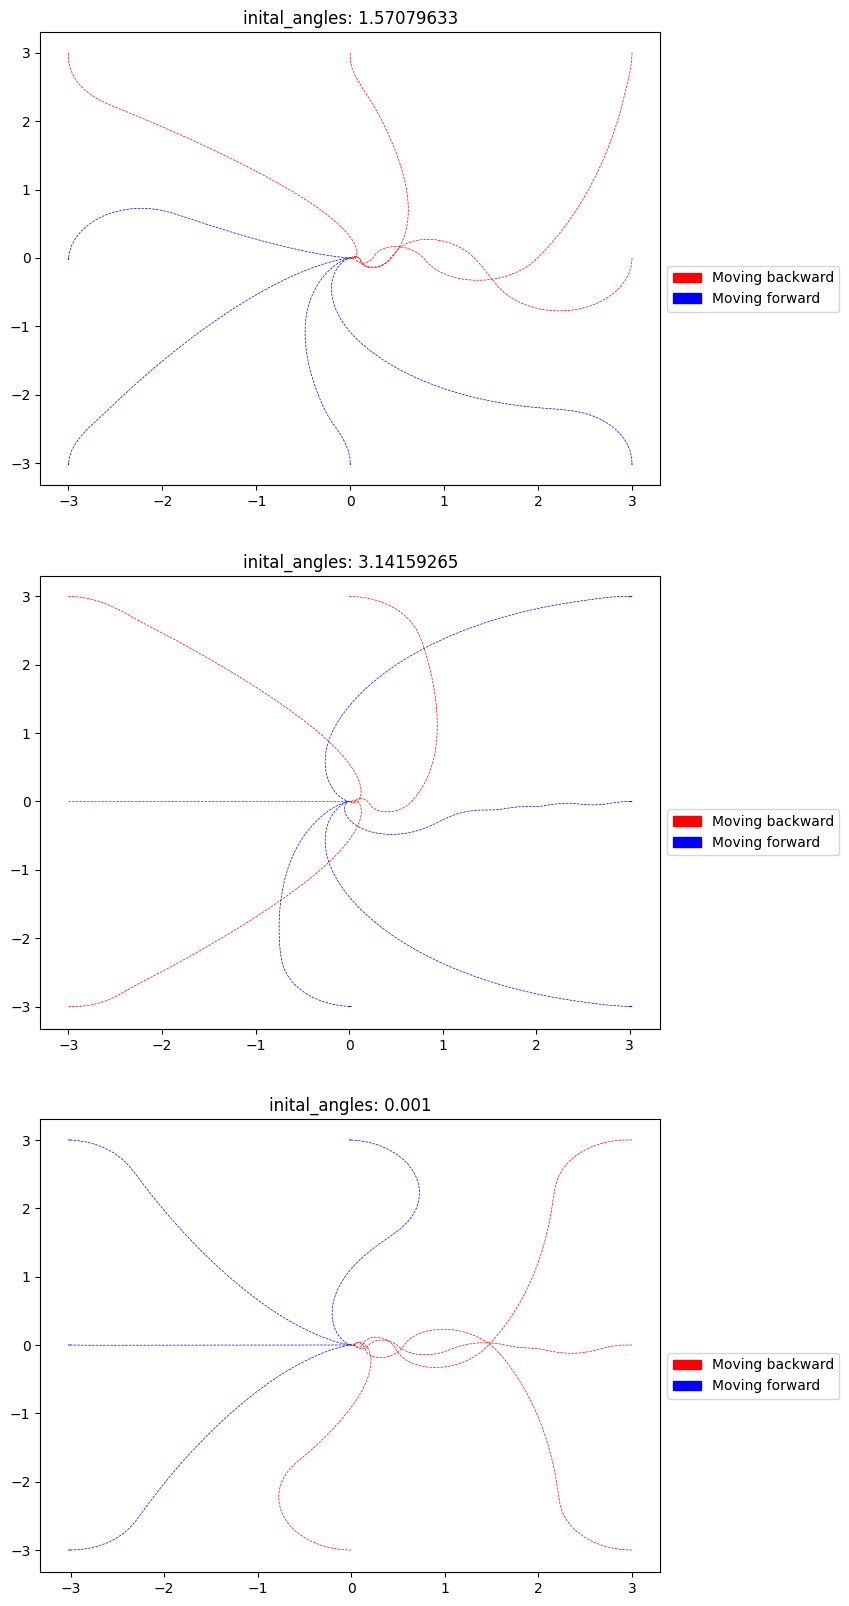

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


inital_angle = np.array([extract_pose_string(p) for p in pose_list])
inital_angles = list(set(inital_angle[:, 2]))

f, axes = plt.subplots(len(inital_angles), 1, sharey=True, figsize=(8, 20))
for i_ax, inital_angle in enumerate(inital_angles):
    for pose in pose_list:
        pose_arr = extract_pose_string(pose)
        if pose_arr[2] != inital_angles[i_ax]:
            continue

        sub_df_2 = sub_df_1[sub_df_1["state_init"] == pose]
        line_style = 'b--' if sub_df_2["v [m/s]"].iloc[5] > 0 else 'r--'
        line_traj, = axes[i_ax].plot(sub_df_2["x [m]"], sub_df_2["y [m]"], line_style, lw=0.5)
        axes[i_ax].set_title("inital_angles: {}".format(inital_angles[i_ax]))

    red_patch = mpatches.Patch(color='red', label='Moving backward')
    blue_patch = mpatches.Patch(color='blue', label='Moving forward')
    axes[i_ax].legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 0.5))


In [70]:
# sub_df_2.loc[sub_df_2["v [m/s]"] > 0] 
# sub_df_2["v [m/s]"]
sub_df_2["v [m/s]"].iloc[5]

-2.2

<Axes: title={'center': 'runned trajectory'}, xlabel='x [m]'>

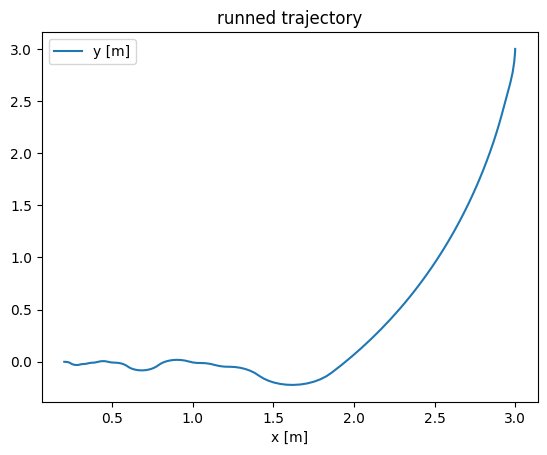

In [9]:
# df.drop(columns=["t [s]", "stage_obj", "accum_obj"]).plot()
df = df[df["t [s]"] > 0.0005]
df.plot(x="x [m]", y="y [m]", title="runned trajectory")

<Axes: title={'center': 'runned trajectory'}, xlabel='t [s]'>

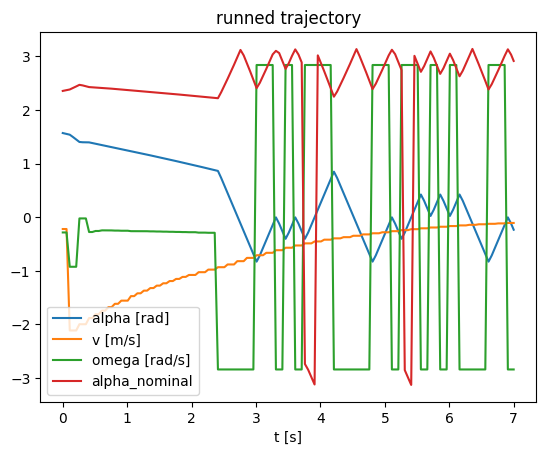

In [10]:
import numpy as np

df["alpha_nominal"] = df.apply(lambda row:-row["alpha [rad]"] + np.arctan2(-row["y [m]"], -row["x [m]"]), axis=1)
df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi - value if value > np.pi else value)
df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi + value if value < -np.pi else value)
# df.plot(x="t [s]", y="alpha", title="runned trajectory")
df.plot(x="t [s]", y=["alpha [rad]", "v [m/s]", "omega [rad/s]", "alpha_nominal"], title="runned trajectory")

In [11]:
k_a = 20
k_b = -0.05

df["beta"] = df.apply(lambda row:-row["alpha [rad]"] - row["alpha_nominal"], axis=1)
df["re-cal-omega"] = df["alpha_nominal"] * k_a + df["beta"] * k_b
print(df.to_markdown())

|     |     t [s] |    x [m] |       y [m] |   alpha [rad] |    run_obj |   accum_obj |   v [m/s] |   omega [rad/s] |   alpha_nominal |     beta |   re-cal-omega |
|----:|----------:|---------:|------------:|--------------:|-----------:|------------:|----------:|----------------:|----------------:|---------:|---------------:|
|   1 | 0.0011    | 3        |  2.9998     |    1.57054    | 1824.55    |     364.922 | -0.22     |      -0.284     |         2.35642 | -3.92696 |        47.3247 |
|   2 | 0.0096257 | 3        |  2.99792    |    1.56812    | 1823.34    |     547.256 | -0.22     |      -0.284     |         2.35853 | -3.92665 |        47.3669 |
|   3 | 0.0596257 | 2.99989  |  2.98693    |    1.55392    | 1816.25    |     728.882 | -0.22     |      -0.284     |         2.37091 | -3.92483 |        47.6144 |
|   4 | 0.109626  | 2.99963  |  2.97593    |    1.53972    | 1809.1     |     909.791 | -2.11269  |      -0.92416   |         2.38331 | -3.92303 |        47.8623 |
|   5 | 0.159626

In [12]:
df
df.plot(x="t [s]", y=["stage_obj"], title="object")
df.plot(x="t [s]", y=["x [m]", "y [m]"], title="object")

KeyError: "None of [Index(['stage_obj'], dtype='object')] are in the [columns]"

In [ ]:
np.arctan2(-1.995, -1.763), np.arctan2(1.995, 1.763)

(-2.294537774150904, 0.8470548794388896)

In [ ]:
import numpy as np

initial_position = np.array(np.meshgrid([-3, 0, 3], [-3, 0, 3])).T.reshape(-1, 2) 

array([-3,  0,  3, -3,  0,  3, -3,  0,  3])

In [ ]:
initial_position

array([[-3, -3],
       [-3,  0],
       [-3,  3],
       [ 0, -3],
       [ 0,  0],
       [ 0,  3],
       [ 3, -3],
       [ 3,  0],
       [ 3,  3]])